### Extended Isolation Forest (EIF) Trial

Experimenting with H2O EIF

In [1]:
import os
import sys

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd())))

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr, kendalltau

from typing import Callable, Any
from sklearn.datasets import make_moons, make_circles
from sklearn.ensemble import IsolationForest as SklearnIsolationForest

from src.isolation.tree import IsolationTree
from src.isolation.forest import IsolationForest
from src.kmeans_isolation.tree import KMeansIsolationTree
from src.kmeans_isolation.forest import KMeansIsolationForest

import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator


# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("All imports successful \u2705")

All imports successful ✅


In [2]:
def time_execution(
    func: Callable, 
    n_runs: int = 5, 
    *args, **kwargs
) -> tuple[float, float]:
    """Time function execution over multiple runs.
    Args:
        func: Function to time
        n_runs: Number of runs for averaging
        *args, **kwargs: Arguments to pass to func
    Returns:
        (mean_time, std_time) in seconds
    """
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        func(*args, **kwargs)
        end = time.perf_counter()
        times.append(end - start)
    return np.float64(np.mean(times)), np.float64(np.std(times))


def generate_rectangles_dataset(
    n_normal: int = 900, 
    n_anomalies: int = 100, 
    seed: int = 42
):
    """Generate 9 rectangles in a 3x3 grid dataset with anomalies."""
    np.random.seed(seed)
    rectangles = []
    for i in range(3):
        for j in range(3):
            Xs_rectangle = np.random.uniform(
                low=[i * 3.0, j * 3.0],
                high=[i * 3.0 + 2.0, j * 3.0 + 2.0],
                size=(n_normal // 9, 2)
            )
            rectangles.append(Xs_rectangle)
    Xs_normal = np.vstack(rectangles)
    
    # Anomalies scattered randomly
    Xs_anomalies = np.random.uniform(
        low=[0.0, 0.0],
        high=[9.0, 9.0],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * len(Xs_normal) + [1] * len(Xs_anomalies))
    return X.astype(np.float64), y


def generate_moons_dataset(
    n_normal: int = 900, 
    n_anomalies: int = 100, 
    seed: int = 42
):
    """Generate moons dataset with anomalies."""
    np.random.seed(seed)
    
    Xs_normal, _ = make_moons(n_samples=n_normal, noise=0.05, random_state=seed)
    
    Xs_anomalies = np.random.uniform(
        low=[Xs_normal[:, 0].min() - 0.5, Xs_normal[:, 1].min() - 0.5],
        high=[Xs_normal[:, 0].max() + 0.5, Xs_normal[:, 1].max() + 0.5],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * len(Xs_normal) + [1] * len(Xs_anomalies))
    return X.astype(np.float64), y


def generate_circles_dataset(
    n_normal: int = 900, 
    n_anomalies: int = 100,
    seed: int = 42
):
    """Generate circles dataset with anomalies."""
    np.random.seed(seed)
    
    Xs_normal, _ = make_circles(n_samples=n_normal, noise=0.0, random_state=seed)
    
    Xs_anomalies = np.random.uniform(
        low=[Xs_normal[:, 0].min() - 0.5, Xs_normal[:, 1].min() - 0.5],
        high=[Xs_normal[:, 0].max() + 0.5, Xs_normal[:, 1].max() + 0.5],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * len(Xs_normal) + [1] * len(Xs_anomalies))
    return X.astype(np.float64), y


def generate_synthetic_dataset(
    n_samples: int, 
    n_features: int, 
    contamination: float = 0.1, 
    seed: int = 42
):
    """Generate synthetic high-dimensional dataset."""
    np.random.seed(seed)
    
    n_normal = int(n_samples * (1 - contamination))
    n_anomalies = n_samples - n_normal
    
    # Normal samples from standard normal
    X_normal = np.random.randn(n_normal, n_features)
    
    # Anomalies from shifted/scaled distribution
    X_anomalies = np.random.randn(n_anomalies, n_features) * 3 + 5
    
    X = np.vstack([X_normal, X_anomalies])
    y = np.array([0] * n_normal + [1] * n_anomalies)
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    return X[indices].astype(np.float64), y[indices]


print("Utility functions defined \u2705")

Utility functions defined ✅


In [3]:
import pyod
from pyod.models.iforest import IForest as PyODIForest
from pyod.models.knn import KNN as PyODKNN  # K-NN based detector as alternative

In [4]:
from pyod.models.lof import LOF
from pyod.models.copod import COPOD
from pyod.models.ecod import ECOD

print("-"*80)
print("PyOD Additional Algorithms Comparison")
print("-"*80)

n_samples_test = 50000
X_test = generate_moons_dataset(n_normal=n_samples_test - 5000, n_anomalies=5000, seed=42)[0]

print(f"\nTesting on {n_samples_test} samples with various PyOD algorithms:\n")

algorithms = [
    ('PyOD IForest', PyODIForest(n_estimators=100, max_samples=256, random_state=42, n_jobs=-1)),
    ('PyOD LOF', LOF(n_neighbors=20, n_jobs=-1)),
    ('PyOD COPOD', COPOD()),
    ('PyOD ECOD', ECOD()),
    ('PyOD KNN', PyODKNN(n_neighbors=20, n_jobs=-1)),
    ('H2o Extended IForest', None),  # Will handle separately
    ('Our IForest', None),    # Will handle separately
    ('Our KMeans IF', None),  # Will handle separately
]

results_pyod_algos = []

for name, clf in algorithms:
    if name == 'Our IForest':
        def train_fn():
            forest = IsolationForest(ensemble_size=100, n_jobs=-1, random_state=42)
            forest.fit(X_test, subsample_size=256)
    elif name == 'Our KMeans IF':
        def train_fn():
            forest = KMeansIsolationForest(ensemble_size=100, n_jobs=-1, random_state=42)
            forest.fit(X_test, subsample_size=256)
    elif name == 'H2o Extended IForest':
        h2o.init(verbose=False)
        h2o.remove_all()
        h2o_X_test = h2o.H2OFrame(X_test)
        def train_fn():
            h2o_clf = H2OExtendedIsolationForestEstimator(
                ntrees=100,
                sample_size=256,
                seed=42
            )
            h2o_clf.train(training_frame=h2o_X_test)
    else:
        def train_fn():
            clf.fit(X_test)
    
    mean_time, std_time = time_execution(train_fn, n_runs=5)
    print(f"  {name:20s}: {mean_time:.4f}s \u00B1 {std_time:.4f}s")
    
    results_pyod_algos.append({
        'Algorithm': name,
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })

df_pyod_algos = pd.DataFrame(results_pyod_algos)

print("\n" + "-"*80)
print("SUMMARY: PyOD Algorithms on 50K samples")
print("-"*80)
print(df_pyod_algos.sort_values('Mean Time (s)').to_string(index=False))

# Save results
df_pyod_algos.to_csv('../results/timing/h2o_algorithms_comparison.csv', index=False)

print("\nResults saved to results/timing/h2o_algorithms_comparison.csv \u2705")

--------------------------------------------------------------------------------
PyOD Additional Algorithms Comparison
--------------------------------------------------------------------------------

Testing on 50000 samples with various PyOD algorithms:

  PyOD IForest        : 0.4116s ± 0.0078s
  PyOD LOF            : 0.1745s ± 0.0022s
  PyOD COPOD          : 0.0714s ± 0.0756s
  PyOD ECOD           : 0.0305s ± 0.0071s
  PyOD KNN            : 0.1346s ± 0.0064s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |███████████

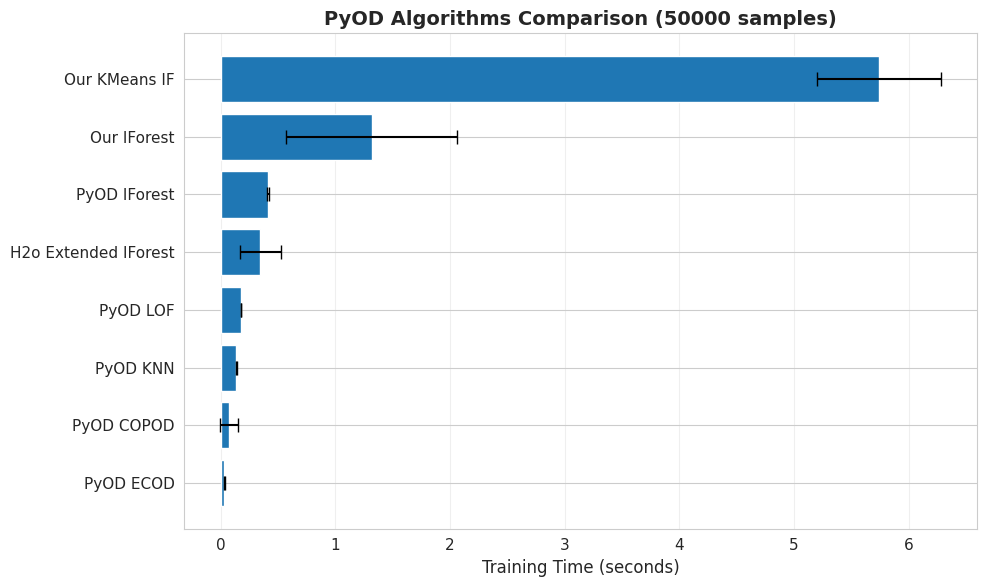


Plot saved to: results/timing/h2o_algorithms_comparison.png ✅


In [5]:
plt.figure(figsize=(10, 6))

df_sorted = df_pyod_algos.sort_values('Mean Time (s)')

plt.barh(df_sorted['Algorithm'], df_sorted['Mean Time (s)'], xerr=df_sorted['Std Time (s)'], capsize=5)

plt.xlabel('Training Time (seconds)', fontsize=12)
plt.title(f'PyOD Algorithms Comparison ({n_samples_test} samples)', fontsize=14, fontweight='bold')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig('../results/timing/h2o_algorithms_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: results/timing/h2o_algorithms_comparison.png \u2705")

In [9]:
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split

print("-" * 80)
print("Prediction Accuracy Comparison")
print("-" * 80)

# Test configurations
datasets_for_accuracy = [
    ('9 Rectangles', generate_rectangles_dataset, {}),
    ('Moons', generate_moons_dataset, {}),
    ('Circles', generate_circles_dataset, {}),
    ('High-Dim (10D)', generate_synthetic_dataset, {'n_samples': 10000, 'n_features': 10}),
    ('Synthetic (20D)', generate_synthetic_dataset, {'n_samples': 20000, 'n_features': 20})
]

ensemble_size = 100
subsample_size = 256
results_accuracy = []

for dataset_name, generator, kwargs in datasets_for_accuracy:
    print(f"\n{'-' * 80}")
    print(f"Dataset: {dataset_name}")
    print(f"{'-' * 80}")
    
    X, y = generator(**kwargs) if kwargs else generator()
    
    # Split into train/test (80/20) with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    contamination = np.mean(y_train)
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Contamination: {contamination:.2%}\n")
    
    # 1. Our IsolationForest
    print(f"{'Method':<30} {'Training...':<15}", end='', flush=True)
    forest_std = IsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
    forest_std.fit(X_train, subsample_size=subsample_size, contamination=contamination)
    
    scores_std = forest_std.scores(X_test)
    preds_std = forest_std.predict(X_test)
    
    bal_acc = balanced_accuracy_score(y_test, preds_std)

    f1 = f1_score(y_test, preds_std)

    precision = precision_score(y_test, preds_std, zero_division=0)

    recall = recall_score(y_test, preds_std)

    roc_auc = roc_auc_score(y_test, scores_std)

    avg_precision = average_precision_score(y_test, scores_std)
    
    print(f"\r{'IsolationForest':<30} {'✓ Complete':<15}")
    print(f"  Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f} | PR-AUC: {avg_precision:.4f}")
    
    results_accuracy.append({
        'Dataset': dataset_name,
        'Method': 'IsolationForest',
        'Balanced Accuracy': bal_acc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'PR-AUC': avg_precision
    })
    
    # 2. Our KMeansIsolationForest
    print(f"\n{'KMeansIsolationForest':<30} {'Training...':<15}", end='', flush=True)
    forest_kmeans = KMeansIsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
    forest_kmeans.fit(X_train, subsample_size=subsample_size, contamination=contamination)
    
    scores_kmeans = forest_kmeans.scores(X_test)

    preds_kmeans = forest_kmeans.predict(X_test)
    
    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_test, preds_kmeans)

    f1 = f1_score(y_test, preds_kmeans)

    precision = precision_score(y_test, preds_kmeans, zero_division=0)

    recall = recall_score(y_test, preds_kmeans)

    roc_auc = roc_auc_score(y_test, scores_kmeans)

    avg_precision = average_precision_score(y_test, scores_kmeans)
    
    print(f"\r{'KMeansIsolationForest':<30} {'✓ Complete':<15}")
    print(f"  Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f} | PR-AUC: {avg_precision:.4f}")
    
    results_accuracy.append({
        'Dataset': dataset_name,
        'Method': 'KMeansIsolationForest',
        'Balanced Accuracy': bal_acc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'PR-AUC': avg_precision
    })
    
    # 3. sklearn IsolationForest
    print(f"\n{'sklearn IsolationForest':<30} {'Training...':<15}", end='', flush=True)
    sklearn_forest = SklearnIsolationForest(
        n_estimators=ensemble_size,
        max_samples=subsample_size,
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    sklearn_forest.fit(X_train)
    
    scores_sklearn = -sklearn_forest.score_samples(X_test)  # Negate for consistency (higher = more anomalous)
    preds_sklearn = (sklearn_forest.predict(X_test) == -1).astype(int)  # -1 for outliers, 1 for inliers
    
    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_test, preds_sklearn)

    f1 = f1_score(y_test, preds_sklearn)

    precision = precision_score(y_test, preds_sklearn, zero_division=0)

    recall = recall_score(y_test, preds_sklearn)

    roc_auc = roc_auc_score(y_test, scores_sklearn)

    avg_precision = average_precision_score(y_test, scores_sklearn)
    
    print(f"\r{'sklearn IsolationForest':<30} {'✓ Complete':<15}")
    print(f"  Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f} | PR-AUC: {avg_precision:.4f}")
    
    results_accuracy.append({
        'Dataset': dataset_name,
        'Method': 'sklearn IsolationForest',
        'Balanced Accuracy': bal_acc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'PR-AUC': avg_precision
    })

    # 4. H2O Extended Isolation Forest
    print(f"\n{'H2O Extended IsolationForest':<30} {'Training...':<15}", end='', flush=True)
    h2o.init(verbose=False)
    h2o.remove_all()
    h2o_X_train = h2o.H2OFrame(X_train)
    h2o_X_test = h2o.H2OFrame(X_test)
    h2o_clf = H2OExtendedIsolationForestEstimator(
        ntrees=ensemble_size,
        sample_size=subsample_size,
        seed=42
    )
    h2o_clf.train(training_frame=h2o_X_train)
    h2o_preds = h2o_clf.predict(h2o_X_test).as_data_frame()
    scores_h2o = h2o_preds['anomaly_score'].values
    preds_h2o = (h2o_preds['anomaly_score'].values > 0.5).astype(int)

    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_test, preds_h2o)
    f1 = f1_score(y_test, preds_h2o)
    precision = precision_score(y_test, preds_h2o, zero_division=0)
    recall = recall_score(y_test, preds_h2o)
    roc_auc = roc_auc_score(y_test, scores_h2o)
    avg_precision = average_precision_score(y_test, scores_h2o)
    print(f"\r{'H2O Extended IsolationForest':<30} {'✓ Complete':<15}")

    results_accuracy.append({
        'Dataset': dataset_name,
        'Method': 'H2O Extended IsolationForest',
        'Balanced Accuracy': bal_acc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'PR-AUC': avg_precision
    })


# Create DataFrame
df_accuracy = pd.DataFrame(results_accuracy)

print("\n" + "-" * 80)
print("ACCURACY SUMMARY")
print("-" * 80)
print(df_accuracy.to_string(index=False))

# Save results
df_accuracy.to_csv('../results/timing/h2o_prediction_accuracy.csv', index=False)
print("\nResults saved to results/timing/h2o_prediction_accuracy.csv \u2705")

--------------------------------------------------------------------------------
Prediction Accuracy Comparison
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Dataset: 9 Rectangles
--------------------------------------------------------------------------------
Train size: 800, Test size: 200
Contamination: 10.00%

IsolationForest                ✓ Complete     
  Balanced Acc: 0.6722 | F1: 0.3750 | Precision: 0.3214 | Recall: 0.4500
  ROC-AUC: 0.7825 | PR-AUC: 0.4513

KMeansIsolationForest          ✓ Complete     
  Balanced Acc: 0.7028 | F1: 0.3218 | Precision: 0.2090 | Recall: 0.7000
  ROC-AUC: 0.7836 | PR-AUC: 0.5812

sklearn IsolationForest        ✓ Complete     
  Balanced Acc: 0.5750 | F1: 0.2326 | Precision: 0.2174 | Recall: 0.2500
  ROC-AUC: 0.6911 | PR-AUC: 0.2802

H2O Extended IsolationForest   Training...    Parse progress: |████████████████████████████████████

/home/mvb/Desktop/Project-Anomaly-Detection-AD/.venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


IsolationForest                ✓ Complete     
  Balanced Acc: 0.9639 | F1: 0.8837 | Precision: 0.8261 | Recall: 0.9500
  ROC-AUC: 0.9975 | PR-AUC: 0.9794

KMeansIsolationForest          ✓ Complete     
  Balanced Acc: 0.8917 | F1: 0.5063 | Precision: 0.3390 | Recall: 1.0000
  ROC-AUC: 0.9811 | PR-AUC: 0.8801

sklearn IsolationForest        ✓ Complete     
  Balanced Acc: 0.9417 | F1: 0.8780 | Precision: 0.8571 | Recall: 0.9000
  ROC-AUC: 0.9883 | PR-AUC: 0.9441

H2O Extended IsolationForest   Training...    Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
H2O Extended IsolationForest   ✓ Complete     

----------------------------------------------------------

/home/mvb/Desktop/Project-Anomaly-Detection-AD/.venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


IsolationForest                ✓ Complete     
  Balanced Acc: 0.9389 | F1: 0.7308 | Precision: 0.5938 | Recall: 0.9500
  ROC-AUC: 0.9922 | PR-AUC: 0.9688

KMeansIsolationForest          ✓ Complete     
  Balanced Acc: 0.8000 | F1: 0.3571 | Precision: 0.2174 | Recall: 1.0000
  ROC-AUC: 0.9903 | PR-AUC: 0.9370

sklearn IsolationForest        ✓ Complete     
  Balanced Acc: 0.9250 | F1: 0.7660 | Precision: 0.6667 | Recall: 0.9000
  ROC-AUC: 0.9783 | PR-AUC: 0.9382

H2O Extended IsolationForest   Training...    Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
H2O Extended IsolationForest   ✓ Complete     

----------------------------------------------------------

/home/mvb/Desktop/Project-Anomaly-Detection-AD/.venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


IsolationForest                ✓ Complete     
  Balanced Acc: 0.9997 | F1: 0.9975 | Precision: 0.9950 | Recall: 1.0000
  ROC-AUC: 1.0000 | PR-AUC: 1.0000

KMeansIsolationForest          ✓ Complete     
  Balanced Acc: 0.9972 | F1: 0.9950 | Precision: 0.9950 | Recall: 0.9950
  ROC-AUC: 1.0000 | PR-AUC: 1.0000

sklearn IsolationForest        ✓ Complete     
  Balanced Acc: 0.9997 | F1: 0.9975 | Precision: 0.9950 | Recall: 1.0000
  ROC-AUC: 1.0000 | PR-AUC: 1.0000

H2O Extended IsolationForest   Training...    Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
H2O Extended IsolationForest   ✓ Complete     

----------------------------------------------------------

/home/mvb/Desktop/Project-Anomaly-Detection-AD/.venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


IsolationForest                ✓ Complete     
  Balanced Acc: 1.0000 | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
  ROC-AUC: 1.0000 | PR-AUC: 1.0000

KMeansIsolationForest          ✓ Complete     
  Balanced Acc: 1.0000 | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
  ROC-AUC: 1.0000 | PR-AUC: 1.0000

sklearn IsolationForest        ✓ Complete     
  Balanced Acc: 1.0000 | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000
  ROC-AUC: 1.0000 | PR-AUC: 1.0000

H2O Extended IsolationForest   Training...    Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
H2O Extended IsolationForest   ✓ Complete     

----------------------------------------------------------

/home/mvb/Desktop/Project-Anomaly-Detection-AD/.venv/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


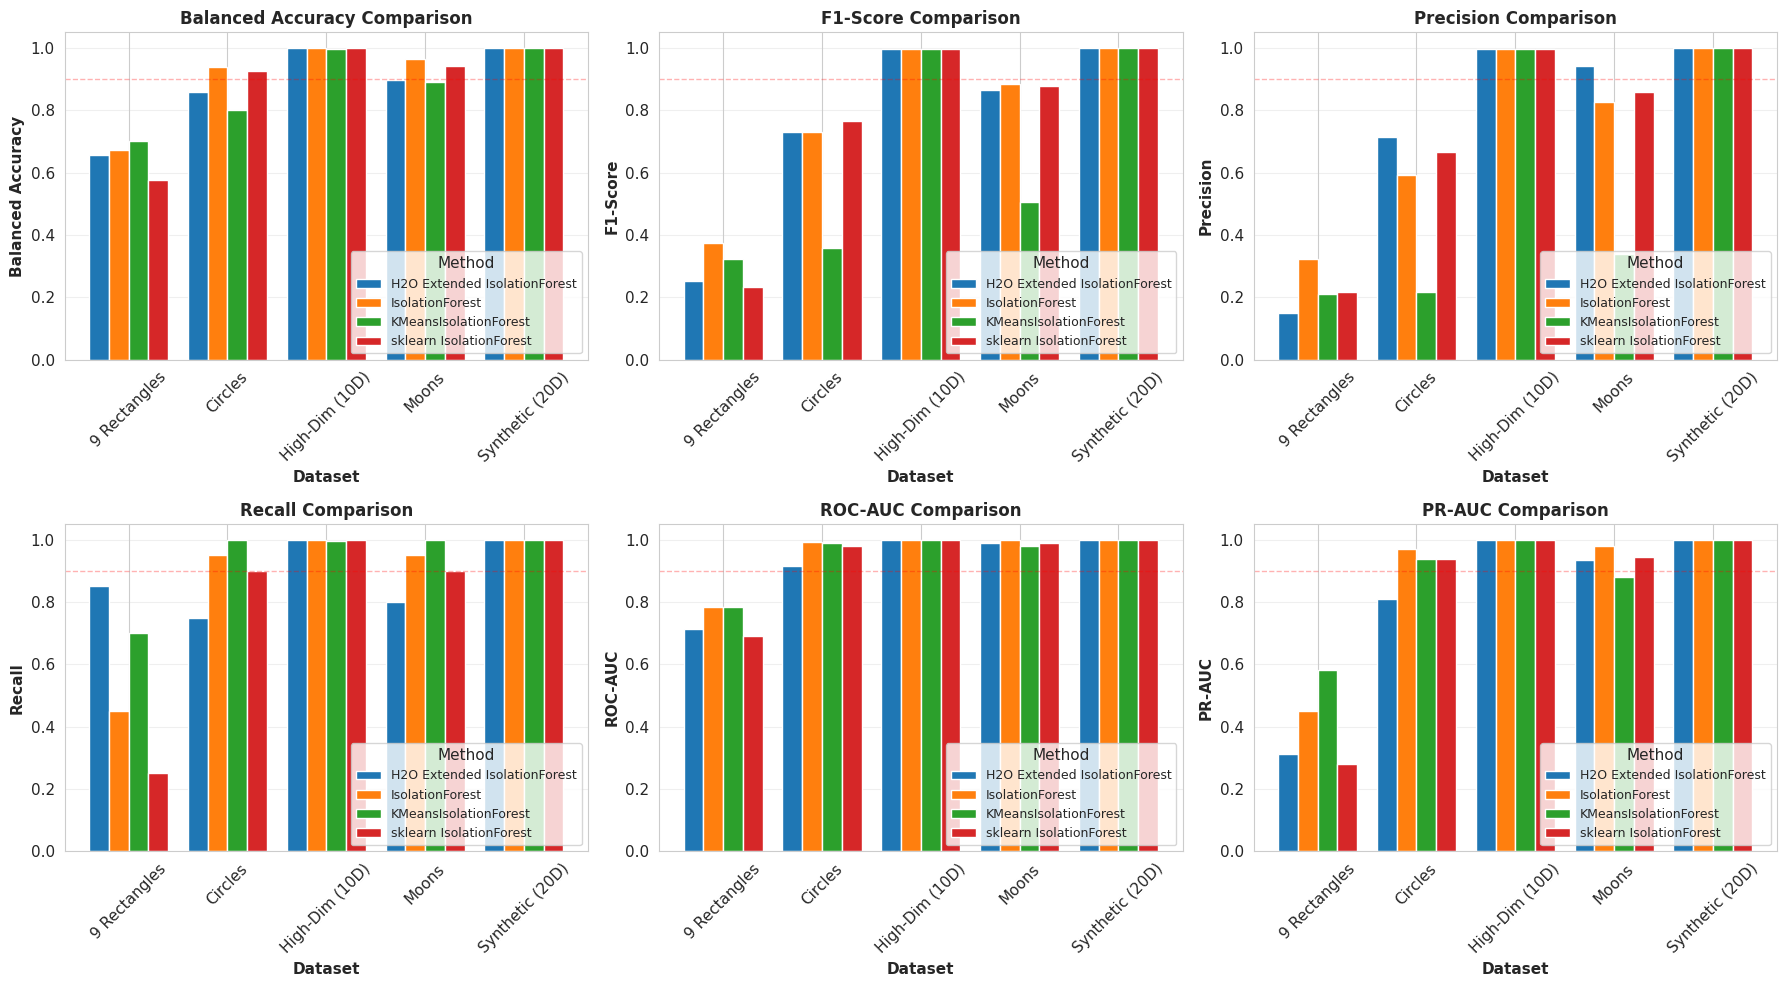

Accuracy metrics plot saved to results/timing/h2o_accuracy_metrics_comparison.png ✅


In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = ['Balanced Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Pivot data for grouped bar chart
    pivot_df = df_accuracy.pivot(index='Dataset', columns='Method', values=metric)
    
    pivot_df.plot(kind='bar', ax=ax, width=0.8, rot=45)

    ax.set_xlabel('Dataset', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')

    ax.legend(title='Method', fontsize=9, loc='lower right')

    ax.grid(axis='y', alpha=0.3)

    ax.set_ylim([0, 1.05])
    
    # Add horizontal line at 0.9 for reference
    ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()

plt.savefig('../results/timing/h2o_accuracy_metrics_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

print("Accuracy metrics plot saved to results/timing/h2o_accuracy_metrics_comparison.png \u2705")

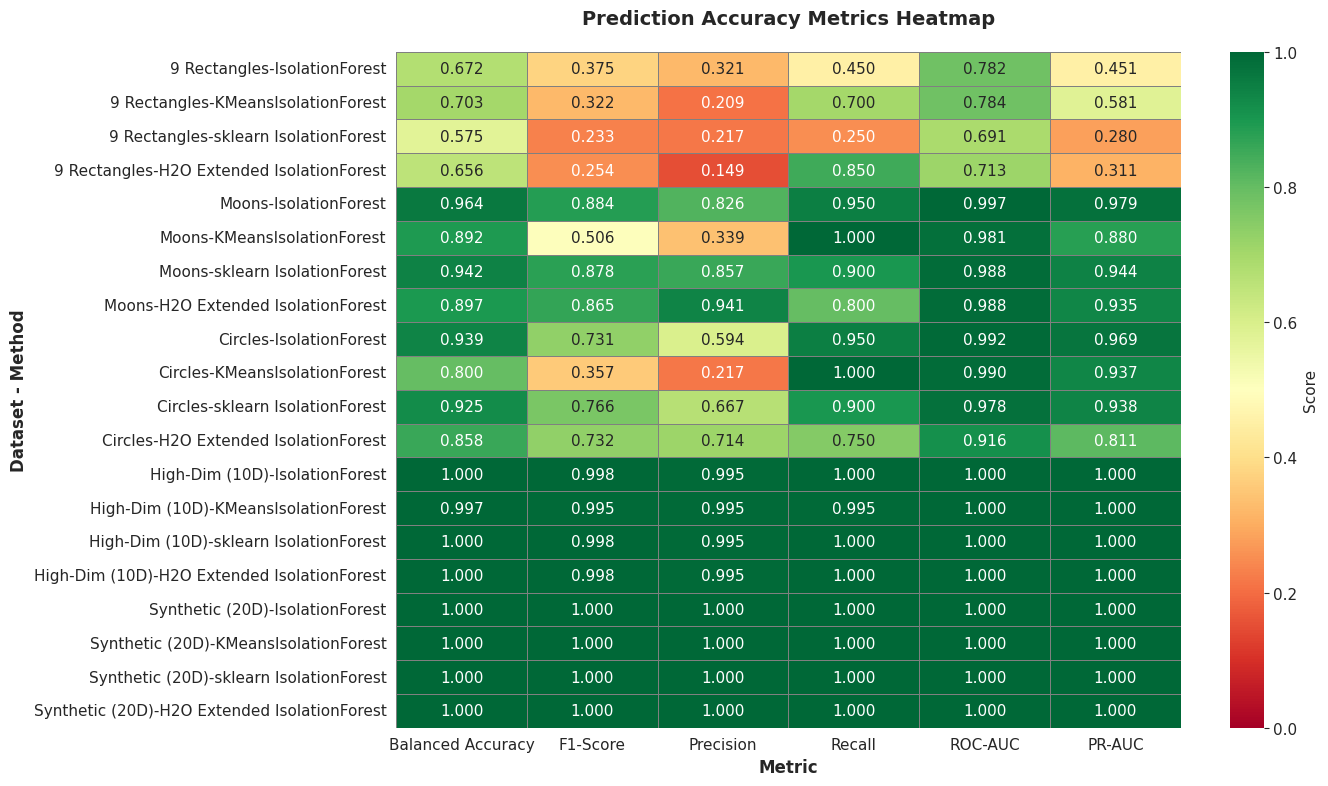

Accuracy heatmap saved to results/timing/h2o_accuracy_heatmap.png ✅


In [11]:
fig, ax = plt.subplots(figsize=(14, 8))

df_accuracy['Dataset-Method'] = df_accuracy['Dataset'] + "-" + df_accuracy['Method']

heatmap_data = df_accuracy.set_index('Dataset-Method')[metrics]

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, cbar_kws={'label': 'Score'},
            linewidths=0.5, linecolor='gray', ax=ax)

ax.set_title('Prediction Accuracy Metrics Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Dataset - Method', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/timing/h2o_accuracy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Accuracy heatmap saved to results/timing/h2o_accuracy_heatmap.png \u2705")

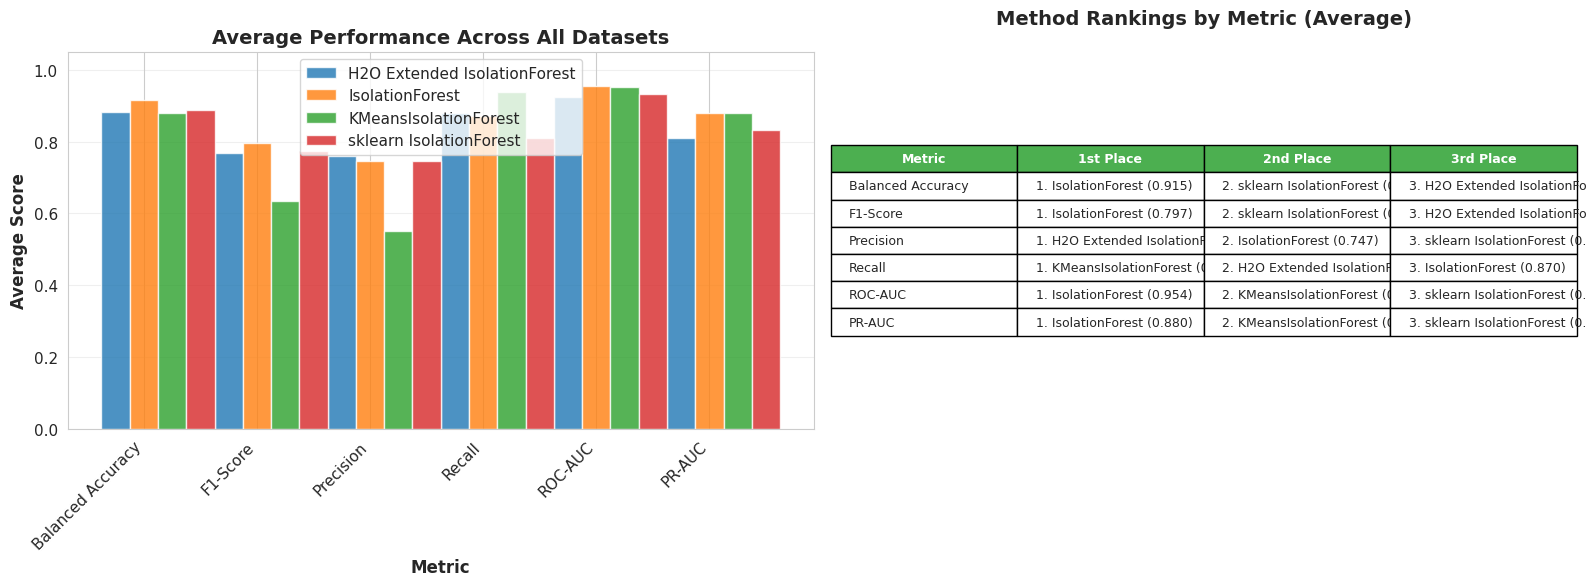

Accuracy summary plot saved to results/timing/h2o_accuracy_summary.png ✅


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

mean_performance = df_accuracy.groupby('Method')[metrics].mean()

# Left Plot: Radar chart style (but using grouped bars)
x = np.arange(len(metrics))
width = 0.25

for i, method in enumerate(mean_performance.index):
    offset = width * (i - 1)
    ax1.bar(x + offset, mean_performance.loc[method], width, label=method, alpha=0.8)

ax1.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Score', fontsize=12, fontweight='bold')
ax1.set_title('Average Performance Across All Datasets', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.05])

# Right Plot: Method ranking table
ax2.axis('off')

# Create ranking table
ranking_data = []
for metric in metrics:
    sorted_methods = df_accuracy.groupby('Method')[metric].mean().sort_values(ascending=False)
    ranking_data.append([
        metric,
        f"1. {sorted_methods.index[0]} ({sorted_methods.iloc[0]:.3f})",
        f"2. {sorted_methods.index[1]} ({sorted_methods.iloc[1]:.3f})",
        f"3. {sorted_methods.index[2]} ({sorted_methods.iloc[2]:.3f})"
    ])

table = ax2.table(cellText=ranking_data, 
                 colLabels=['Metric', '1st Place', '2nd Place', '3rd Place'],
                 cellLoc='left', loc='center',
                 colWidths=[0.25, 0.25, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax2.set_title('Method Rankings by Metric (Average)', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../results/timing/h2o_accuracy_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Accuracy summary plot saved to results/timing/h2o_accuracy_summary.png \u2705")

In [6]:
print("-"*80)
print("Three-way Isolation Forest Comparison")
print("-"*80)

# Test configurations
n_estimators = 100
dataset_sizes = [1000, 5000, 10000, 50000]

results_three_way = []

print("\nComparing:")
print("  1. Our IsolationForest (parallel)")
print("  2. PyOD IForest")
print("  3. sklearn IsolationForest")
print("  4. h2o Extended IsolationForest")

print(f"\nDataset sizes: {dataset_sizes}")
print(f"Ensemble size: {n_estimators} trees\n")

for n_samples in dataset_sizes:
    print(f"\nTesting with {n_samples} samples...")
    
    # Generate test data
    X_test = make_moons(n_samples=n_samples, noise=0.1, random_state=42)[0]
    
    # 1. Our IsolationForest
    def train_our_forest():
        forest = IsolationForest(ensemble_size=n_estimators, n_jobs=-1, random_state=42)
        forest.fit(X_test, subsample_size=256)
    
    mean_time_ours, std_time_ours = time_execution(train_our_forest, n_runs=5)
    print(f"  Our IForest:    {mean_time_ours:.4f}s ± {std_time_ours:.4f}s")
    
    # 2. PyOD IForest
    def train_pyod_forest():
        clf = PyODIForest(n_estimators=n_estimators, max_samples=256, random_state=42, n_jobs=-1)
        clf.fit(X_test)
    
    mean_time_pyod, std_time_pyod = time_execution(train_pyod_forest, n_runs=5)
    print(f"  PyOD IForest:   {mean_time_pyod:.4f}s ± {std_time_pyod:.4f}s")
    
    # 3. sklearn IForest
    def train_sklearn_forest():
        clf = SklearnIsolationForest(n_estimators=n_estimators, max_samples=256, random_state=42, n_jobs=-1)
        clf.fit(X_test)
    
    mean_time_sklearn, std_time_sklearn = time_execution(train_sklearn_forest, n_runs=5)
    print(f"  sklearn IForest: {mean_time_sklearn:.4f}s \u00B1 {std_time_sklearn:.4f}s")
    
    # 4. h2o Extended IsolationForest
    def train_h2o_forest():
        h2o.init(verbose=False)
        h2o.remove_all()
        h2o_X_test = h2o.H2OFrame(X_test)
        h2o_clf = H2OExtendedIsolationForestEstimator(
            ntrees=n_estimators,
            sample_size=256,
            seed=42
        )
        h2o_clf.train(training_frame=h2o_X_test)

    mean_time_h2o, std_time_h2o = time_execution(train_h2o_forest, n_runs=5)
    print(f"  h2o Extended IForest: {mean_time_h2o:.4f}s ± {std_time_h2o:.4f}s")


    results_three_way.extend([
        {
            'Method': 'Our IForest',
            'Library': 'Custom',
            'Dataset Size': n_samples,
            'Mean Time (s)': mean_time_ours,
            'Std Time (s)': std_time_ours
        },
        {
            'Method': 'PyOD IForest',
            'Library': 'PyOD',
            'Dataset Size': n_samples,
            'Mean Time (s)': mean_time_pyod,
            'Std Time (s)': std_time_pyod
        },
        {
            'Method': 'sklearn IForest',
            'Library': 'sklearn',
            'Dataset Size': n_samples,
            'Mean Time (s)': mean_time_sklearn,
            'Std Time (s)': std_time_sklearn
        },
        {
            'Method': 'h2o Extended IForest',
            'Library': 'h2o',
            'Dataset Size': n_samples,
            'Mean Time (s)': mean_time_h2o,
            'Std Time (s)': std_time_h2o
        }
    ])

# Convert to DataFrame
df_three_way = pd.DataFrame(results_three_way)

print("\n" + "-"*80)
print("SUMMARY: Four-way IForest Comparison")
print("-" * 80)
print(df_three_way.to_string(index=False))

print("\n" + "-"*80)
print("SPEEDUP ANALYSIS (relative to sklearn)")
print("-"*80)

for n_samples in dataset_sizes:
    subset = df_three_way[df_three_way['Dataset Size'] == n_samples]
    sklearn_time = subset[subset['Method'] == 'sklearn IForest']['Mean Time (s)'].values[0]
    
    print(f"\n{n_samples} samples:")
    for method in ['Our IForest', 'PyOD IForest', 'h2o Extended IForest']:
        method_time = subset[subset['Method'] == method]['Mean Time (s)'].values[0]
        speedup = sklearn_time / method_time
        print(f"  {method:20s}: {speedup:5.2f}x {'faster' if speedup > 1 else 'slower'}")

# Save results
df_three_way.to_csv('../results/timing/four_way_iforest_comparison.csv', index=False)

print("\nResults saved to results/timing/four_way_iforest_comparison.csv \u2705")

--------------------------------------------------------------------------------
Three-way Isolation Forest Comparison
--------------------------------------------------------------------------------

Comparing:
  1. Our IsolationForest (parallel)
  2. PyOD IForest
  3. sklearn IsolationForest
  4. h2o Extended IsolationForest

Dataset sizes: [1000, 5000, 10000, 50000]
Ensemble size: 100 trees


Testing with 1000 samples...
  Our IForest:    0.2309s ± 0.0342s
  PyOD IForest:   0.0855s ± 0.0034s
  sklearn IForest: 0.0690s ± 0.0038s
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| 

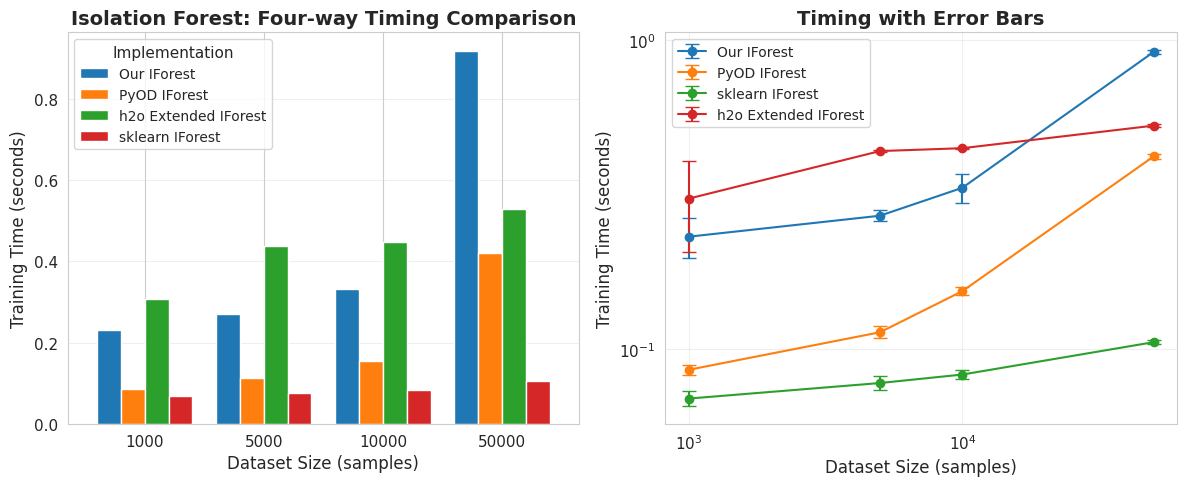


Plot saved to: results/timing/four_way_iforest_comparison.png ✅


In [7]:
plt.figure(figsize=(12, 5))

# Left Plot: Bar chart comparison
plt.subplot(1, 2, 1)
pivot_data = df_three_way.pivot(index='Dataset Size', columns='Method', values='Mean Time (s)')
pivot_data.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Isolation Forest: Four-way Timing Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Size (samples)', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.legend(title='Implementation', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Right Plot: Line plot with error bars
plt.subplot(1, 2, 2)
for method in df_three_way['Method'].unique():
    subset = df_three_way[df_three_way['Method'] == method]
    plt.errorbar(subset['Dataset Size'], subset['Mean Time (s)'], 
                 yerr=subset['Std Time (s)'], marker='o', capsize=5, label=method)
plt.title('Timing with Error Bars', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Size (samples)', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

plt.savefig('../results/timing/four_way_iforest_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: results/timing/four_way_iforest_comparison.png \u2705")